# Getting Started with Accelerated Computing

Some CUDA & OpenACC practical examples

Let's execute the cell below to display information about the GPUs running on the server.

In [2]:
!nvidia-smi

Tue Aug 15 12:04:02 2017       
+------------------------------------------------------+                       
| NVIDIA-SMI 346.46     Driver Version: 346.46         |                       
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GRID K520           On   | 0000:00:03.0     Off |                  N/A |
| N/A   20C    P8    17W / 125W |     10MiB /  4095MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Introduction to GPU Computing

You may not realize it, but GPUs (GPU is short for Graphics Processing Unit) are good for much more than displaying great graphics in video games. In fact, there is a good chance that your daily life is being affected by GPU-accelerated computing.

GPU-accelerated computing is the use of a graphics processing unit (GPU) together with a CPU to accelerate scientific, engineering, mobile and enterprise applications. Pioneered by NVIDIA, GPUs now power energy-efficient datacenters in government labs, universities, enterprises, and small-and-medium businesses around the world.

### How Applications Accelerate With GPUs
GPU-accelerated computing offers unprecedented application performance by offloading compute-intensive portions of the application to the GPU, while the remainder of the code still runs on the CPU. From a user's perspective, applications simply run significantly faster.

![](files/images/how-gpu-acceleration-works.png)

### CPU Versus GPU
A simple way to understand the difference between a CPU and GPU is to compare how they process tasks. A CPU consists of a few cores optimized for sequential serial processing while a GPU consists of thousands of smaller, more efficient cores designed for handling multiple tasks simultaneously.
 
GPUs have thousands of cores to process parallel workloads efficiently

![](files/images/cpu-and-gpu.jpg)

There are hundreds of industry-leading applications already GPU-accelerated. Find out if the applications you use are GPU-accelerated by looking in NVIDIA's [application catalog](http://www.nvidia.com/content/tesla/pdf/gpu-apps-catalog-sept13-digital-fnl-hr.pdf).

### How to Accelerate Applications

If GPU-acceleration is not already available for your application, you may be interested in developing GPU-accelerated code yourself. There are three main methods methods to achieve GPU-acceleration in your code, and that is what the rest of this lab attempts to demonstrate.  The methods are summarized below.

<img src="files/images/three_methods.png" />


Enough introduction, let's start the hands-on work!

## Compiler Directives

Now that we've seen how libraries can be used to help accelerate your code, let's move on to a more flexible approach; using compiler directives.  Here we will provide hints to the compiler and let it accelerate the code for us.  So while this is not quite as easy as using a library, it is more flexible and yet does not require you to modify the underlying source code.  

Open-specification [OpenACC](http://www.openacc.org/) directives are a straightforward way to accelerate existing Fortran, C and C++ applications. With OpenACC directives, you provide hints via compiler directives (or 'pragmas') to tell the compiler where - and how - it should parallelize compute-intensive code for execution on an accelerator. 

If you've done parallel programming using OpenMP, OpenACC is very similar: using directives, applications can be parallelized *incrementally*, with little or no change to the Fortran, C or C++ source. Debugging and code maintenance are easier. OpenACC directives are designed for *portability* across operating systems, host CPUs, and accelerators. You can use OpenACC directives with GPU accelerated libraries, explicit parallel programming languages (e.g., CUDA), MPI, and OpenMP, *all in the same program.*

To demonstrate the power of OpenACC, we're going to look at a very simple Matrix [Transpose](http://en.wikipedia.org/wiki/Transpose) code.  This task just involves compiling and running the source to show the differences in performance between an 8-thread [OpenMP](http://openmp.org/wp/) version of the code running on the CPU, and the OpenACC version running on the GPU.

The source code found below is broken up into these functions:

* `referenceTranspose` - the naive transpose function executed in parallel on the CPU using OpenMP
* `openACCTranspose` - the naive transpose function executed on the massively parallel GPU using OpenACC
* `time_kernel` - a helper function used to measure the bandwidth of running the `referenceTranpose` function
* `time_kernel_acc` - a helper function used to measure the bandwidth of running the `openACCTranpose` function

While it's not important to understand all this code, there are a few important take aways.

1. The OpenACC version of the transpose is compared against the OpenMP version to check for correctness
2. In order to get an accurate bandwidth measurement, each version of the transpose is run 500 times and the average is taken from those runs.
3. There is no GPU-specific code being used in this example.  All acceleration is implemented by the OpenACC [PGI](http://www.pgroup.com/) compiler for you.

Before executing the code, you should look for the following OpenACC directives and see if you can understand their purpose in the code:

* `#pragma acc parallel loop collapse(2) present(in,out)` (line 28) - The `parallel` OpenACC directive tells the compiler that it should offload the code in the structured code block following the `#pragma` (in our case the nested for-loops) following our further instructions and execute it on the GPU. The `loop` tells the compiler to parallelize the next loop.  `collapse(2)` says to apply this directive to the next two loops.  And finally the `present(in,out)` tells the compiler we've already copied the `in` and `out` data to the device.
* `#pragma acc data copyin(in[0:rows*cols]) copyout(out[0:rows*cols])` (line 94) - The `data` directive is used to tell the compiler how and when to move data between the CPU (host) memory and the GPU memory.  Since we are executing each transpose function 500 times, it doesn't make sense to copy the input and output data across the PCI-Express bus for each iteration as this would severely skew the timing results.  This directive says "At the beginning of this pragma, copy the input data to the device.  At the end of the structured code block, copy the output data from the device to the host memory."
* `#pragma acc wait` (line 102) - The `wait` directive tells the compiler that it should wait at this point for all the work on the device to complete.  Since the CPU and GPU are two separate processors, they are able to execute code independently.  If this `wait` was not there, the timing code would be incorrect as the CPU would not wait for the GPU to finish its work before executing the next line of code.

To look at the code, click on the `transpose.c` filename below.  If you decide to make changes to the code, make sure to click the Save button in the text editor box (not the tool bar at the top of the browser tab).

In [3]:
%%bash
pwd; ls -l

/home/ebaldi/Dropbox/PhD/Group meetings/GPU computing/Practicals
total 232
-rw-r--r-- 1 ebaldi COSMO-unit 228427 Aug 21 15:39 Accelerated Computing.ipynb
-rw-r--r-- 1 ebaldi COSMO-unit   3342 Aug 21 15:32 transpose.c


In [4]:
!pgcc -o transpose -acc -Minfo=accel -ta=tesla:kepler transpose.c && echo "Compiled Successfully"

openACCTranspose:
     28, Generating present(in[:],out[:])
         Accelerator kernel generated
         Generating Tesla code
         29, #pragma acc loop gang, vector(128) collapse(2) /* blockIdx.x threadIdx.x */
         31,   /* blockIdx.x threadIdx.x collapsed */
time_kernel_acc:
     95, Generating copyout(out[:cols*rows])
         Generating copyin(in[:cols*rows])
Compiled Successfully


To run the task after you have successfully compiled, execute the next cell.  You should see the GPU is about 3.7x faster than the 8-thread OpenMP verison of the code.  Not bad for only adding three `#pragma`'s.  

In [5]:
%%bash
export OMP_NUM_THREADS=8
./transpose

OpenMP Processors: 8
CPU+OMP: Kernel bandwidth: 4.703913 gb/sec
CPU+OpenACC: Kernel bandwidth: 11.995856 gb/sec


The high-level flow recommended to take with OpenACC is as follows:

1. Identify the computationally intensive portions of your code - these are usually good targets for OpenACC. Use any popular CPU profiling tool, the [nvprof tool](http://docs.nvidia.com/cuda/profiler-users-guide/index.html#nvprof-overview) provided in the CUDA toolkit from NVIDIA, and see which functions take up the most amount of time.
2. Accelerate the code on the GPU using `kernels` or the `parallel` OpenACC directives.  It's very important to verify accuracy of the results at this stage.  Don't focus on performance yet.
3. Once the code is correctly accelerated, optimize data movement with the various data directives. **This is where you will usually begin to see increases in performance**.  Often people get discouraged when they don't see any speedups, or even slowdowns, after step #2.  It's important to continue to step #3.
4. Perform any additional optimizations if needed and repeat the steps.

### Task #3

While compiler directives generally are associated with C, C++ and Fortran, let's see how we can use a similar approach in Python with the `@vectorize` decorator and the [Continuum Analytics](http://continuum.io/) [Numba](http://numba.pydata.org/) compiler.

First let's execute a CPU-only version of a Monte Carlo Options Pricer simulation code. It's not important to understand exactly what this code is doing, only that we get a similar stock price between the two versions.  We also want to look at the `time elapsed` value in the text output.

Execute the next cell to load the common code into our namespace.  You can download this code at the end of the lab if you wish to look at it in more detail.

In [11]:
%run -i monte.py

Execute the following cell to run the CPU version of the `step` function.  This should generate text output and a graph in about 15 seconds.

Result
         stock price: 22.6403881269
      standard error: 0.000250550331068
            paid off: 1.14039250686
        option price: 1.04921175642
Performance
        Mstep/second: 10.37
        time elapsed: 14.468s
Plotting 50/1500000 paths


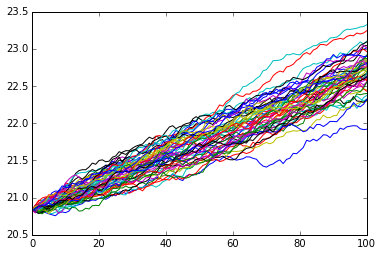

In [12]:
%matplotlib inline
def step_cpu(prices, dt, c0, c1, noises):
    return prices * np.exp(c0 * dt + c1 * noises)

driver(step_cpu, do_plot=True)

Now, let's accelerate the `step` function on the GPU.  To do this, we're going to use a Python decorator.  Using the `@vectorize` decorator, numba can compile the `step` function into a [ufunc (universal function)](http://docs.scipy.org/doc/numpy/reference/ufuncs.html) that operates over [NumPy](http://www.numpy.org/) arrays as fast as traditional ufuncs written in C!

`@vectorize` in numba works by running through all of the elements of the input arrays executing the scalar function on each set.  This means that our `step_gpu` function needs to be a scalar function - taking scalar inputs and returning a scalar output.  To accomplish this, the only thing we have to modify is to use `math.exp` which operates on scalars instead of `np.exp` which expects a NumPy array.

Since a compiler is trying to turn the `step_gpu` function into machine code, we need to provide it with some information about the data types being passed in. That's the first parameter you see being passed to `@vectorize`.

Finally, we are targeting the GPU with this decorator (the second parameter).  And that's it! The compiler handles the work of generating the GPU code, performing any data movement required, and launching the work.  Go ahead and execute the below cell to see what kind of speed up we get.

In [ ]:
from numba import vectorize
import math # needed for the math.exp function

@vectorize(['float64(float64, float64, float64, float64, float64)'], target='cuda')
def step_gpu(prices, dt, c0, c1, noises):
    return prices * math.exp(c0 * dt + c1 * noises)

driver(step_gpu, do_plot=True)

You should see about a 27% increase in speed.  

In the interest of transperency, if you change the `target` to `parallel` instead of `cuda`, the compiler will target the multi-core CPU availalbe on this instance and you will get similar performance to what you just got on the GPU.  The reason for this is we're only porting a very small amount of computation the GPU, and therefore not hiding the latency of transferring data around.  If you decide to take the Python labs on [nvidia.qwiklab.com](https://nvidia.qwiklab.com/), you will see how we can achieve much greater increases in performance of this algorithm by moving more computation to the GPU with both library calls and some CUDA code, and hiding the cost of trasnferring data.

## CUDA

Programming for the GPU in a CUDA-enabled language is the most flexible of the three approaches.  While CUDA was initially just a C compiler when it was first released, it has grown into the parallel computing platform for accessing the general purpose, massively parallel compute power of an NVIDIA GPU.

There is a growing list of languages that understand how to speak CUDA and target the GPU including but not limited to C, C++, Fortran, R, and Python.  In this lab, you will write some CUDA code directly in Python.  This code will be compiled using [Continuum Analytics](http://continuum.io/) [Numba](http://numba.pydata.org/numba-doc/0.13.4/CUDAJit.html) compiler which contains CUDA Python support.

### Task #4

This task does not require any modifications to get working and will be generating the [Mandelbrot Set](http://en.wikipedia.org/wiki/Mandelbrot_set).  It is designed to show you the speed-up you can get using CUDA Python to move computational intensive portions of code to the GPU.

Executing the below cell will run the same algorithm on first the GPU and then again on the CPU.  Both of these examples are using code compiled from Python using the Numba compiler.  The timing of the GPU includes all data transfers between the CPU memory and GPU memory in order to make a fair comparison.  While it's not explicitly coded, the Numba compiler is able to recognize and handle the need for the `gimage` data to be tranferred to the GPU before `create_fractal_gpu` is called, and back when it's complete.  The `cuda.synchronize` is there to ensure the timing information is accurate.

Feel free to change the `numIters` variable to decrease or increase the number of iterations performed.  In addition you can modify the fractal grid points (starting values of `-2.0, 1.0, -1.0, 1.0`) to change the area of the fractal processed.  As you increase the number of iterations, you should see the gap in performance between the GPU and CPU increasing as the amount of computation hides the data transfer latency.

You will notice that the GPU version adds `[griddim, blockdim]` before the parameter list.  These values control how the parallel work is spread across the GPU and will be described in more detail in the next task.  **You should run the next cell twice, the first time may be slower due to the one-time compilation of the `create_fractal_*` functions**

In [ ]:
from mymandel import *
numIters = 20

# Run the GPU Version first
gimage = np.zeros((1024, 1536), dtype = np.uint8)
blockdim = (32, 8)
griddim = (32, 16)

with mytimer('Mandelbrot created on GPU'):
    create_fractal_gpu[griddim, blockdim](-2.0, 1.0, -1.0, 1.0, gimage, numIters)
    cuda.synchronize

imshow(gimage)
show()

# Run the CPU Version last
image = np.zeros_like(gimage)

with mytimer('Mandelbrot created on CPU'):
    create_fractal_cpu(-2.0, 1.0, -1.0, 1.0, image, numIters) 

imshow(image)
show()

You should see around a 9x speed increase when moving from the GPU to the CPU when using the original parameters.

If you are interested in seeing the rest of the code used in the above example, please execute the next cell.  This is not a requirement for the lab, but you may find it insightful after you perform the next task.  In addition, at the end of this lab, you are presented with a section on downloading the code for offline viewing - but be careful you don't run out of time!

In [ ]:
%load mymandel.py

### Task 5 - Hello World

For this task, you get to try your hand and writing some CUDA Python code.  We are going to be using the following concepts:

* <code style="color:green">@cuda.autojit</code> - this decorator is used to tell the CUDA compiler that the function is to be compiled for the GPU.  With `autojit`, the compiler will try and determine the type information of the variables being passed in.  You can create your own signatures manually by using the `jit` decorator.
* <code style="color:green">cuda.blockIdx.x</code> - this is a read-only variable that is defined for you.  It is used within a GPU kernel to determine the ID of the block which is currently executing code.  Since there will be many blocks running in parallel, we need this ID to help determine which chunk of data that particular block will work on.
* <code style="color:green">cuda.threadIdx.x</code> - this is a read-only variable that is defined for you.  It is used within a GPU kernel to determine the ID of the thread which is currently executing code in the active block.
* <code style="color:green">myKernel\[number_of_blocks, threads_per_block\](...)</code> -  this is the syntax used to launch a kernel on the GPU.  Inside the list (the square brackets `[...]`), the first number is the total number of blocks we want to run on the GPU, and the second is the number of threads there are per block.  It's possible, and in fact recommended, for one to schedule more blocks than the GPU can actively run in parallel.  The system will just continue executing blocks until they have all completed.  The following video addresses grids, blocks, and threads in more detail.

<div align="center"><iframe width="640" height="390" src="http://www.youtube.com/embed/KM-zbhyz9f4" frameborder="0" allowfullscreen></iframe></div>

Let's explore the above concepts by doing a simple "Hello World" example.

Most of the code in this example has already been written for you.  Your task is to modify the single line in the `hello` function such that the data printed out at the end looks like:

`[[0 0 0 0 0]]`

What's happening is that all the threads in block 0 are writing the block ID into their respective place in the array.  Remember that this function is being run in parallel by the threads in block 0, each with their own unique thread ID.  Since we're launching a single block with 5 threads, the following is happening parallel:

    data[0,0] = 0
    data[0,1] = 0
    data[0,2] = 0
    data[0,3] = 0
    data[0,4] = 0

If you get stuck, click on the link below the code to see the solution.

In [ ]:
from numba import *
import numpy as np

@cuda.jit
def hello(data):
    data[  ,  ] = 
    
numBlocks = 1
threadsPerBlock = 5

data = np.ones((numBlocks, threadsPerBlock), dtype=np.uint8)

hello[numBlocks,threadsPerBlock](data)

print data

See the solution [below](#Task-#5-Solution)

Once you have a solution generating the correct output, try increasing the number of blocks by a few and see if you understand the output you get.  Be careful about making the number of blocks too big, as it may take a while to print out all those values!  In addition, there is a limit on the number of overall threads, the number of blocks, and the number of threads per block you can request.

## Learn More

If you are interested in learning more, you can use the following resources:

* More labs are available at [nvidia.qwiklab.com](https://nvidia.qwiklab.com)
 * CUDA/GPU Registered Developers with NVIDIA will periodically receive free Credits for use on nvidia.qwiklab.com.  [Sign up today](https://developer.nvidia.com/registered-developer-programs)!
* Learn more at the [CUDA Developer Zone](https://developer.nvidia.com/category/zone/cuda-zone).
* If you have an NVIDIA GPU in your system, you can download and install the [CUDA toolkit](https://developer.nvidia.com/cuda-toolkit) which comes packed with lots of sample code to look at.  Otherwise you can go to [docs.nvidia.com/cuda](http://docs.nvidia.com/cuda) and explore the samples there.
* Take the fantastic online and **free** Udacity [Intro to Parallel Programming](https://www.udacity.com/course/cs344) course which uses CUDA C.
* Search or ask questions on [Stackoverflow](http://stackoverflow.com/questions/tagged/cuda) using the cuda tag
* NVIDIA provided hands-on training at major conferences such as SuperComputer and its own GPU Technology Conference.

<a id="post-lab"></a>
## Post-Lab

Finally, don't forget to save your work from this lab before time runs out and the instance shuts down!!

1. Save this IPython Notebook by going to `File -> Download as -> IPython (.ipynb)` at the top of this window.  *Please note that the in-browser text editors, and likely the executable cells, will not work if you run this IPython Notebook locally.*
2. You can execute the following cell block to create a zip-file of the files you've been working on, and download it with the link below.

In [ ]:
%%bash
rm -f gpu_computing.zip
zip -r gpu_computing task*/* *.py

**After** executing the above cell, you should be able to download the zip file [here](files/gpu_computing.zip)

<a id="FAQ"></a>
---
# Lab FAQ

Q: I'm encountering issues executing the cells, or other technical problems?<br>
A: Please see [this](https://developer.nvidia.com/self-paced-labs-faq#Troubleshooting) infrastructure FAQ.

Q: I'm getting unexpected behavior (i.e., incorrect output) when running any of the tasks.<br>
A: It's possible that one or more of the CUDA Runtime API calls are actually returning an error, but the code above is not checking for this (due to the time constraints of this lab).  Try checking the return value of any CUDA Runtime API call and see if the value is non-zero indicating an error.

## Solutions

### Task #5 Solution

```
from numba import *
import numpy as np

@cuda.jit
def hello(data):
    data[cuda.blockIdx.x,cuda.threadIdx.x] = cuda.blockIdx.x
    
numBlocks = 1
threadsPerBlock = 5

data = np.ones((numBlocks, threadsPerBlock), dtype=np.uint8)

hello[numBlocks,threadsPerBlock](data)

print data
```

[Return](#Task-5---Hello-World)

<style>
p.hint_trigger{
  margin-bottom:7px;
  margin-top:-5px;
  background:#64E84D;
}
.toggle_container{
  margin-bottom:0px;
}
.toggle_container p{
  margin:2px;
}
.toggle_container{
  background:#f0f0f0;
  clear: both;
  font-size:100%;
}
</style>
<script>
$("p.hint_trigger").click(function(){
   $(this).toggleClass("active").next().slideToggle("normal");
});
   
$(".toggle_container").hide();
</script>